In [1]:
import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL 2023-1/차원축소 세션 준비/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [4]:
X_features=fashion.drop(['label'],axis=1)
y_label=fashion['label']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.3, stratify=y_label)

In [6]:
X_train=X_train.reset_index().drop(['index'],axis=1)
X_test=X_test.reset_index().drop(['index'],axis=1)
y_train=y_train.reset_index().drop(['index'],axis=1)
y_test=y_test.reset_index().drop(['index'],axis=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 784) (18000, 784) (42000, 1) (18000, 1)


In [7]:
#시간이 오래 걸리는 관계로 5000개, 1000개만 뽑아서 사용
X_train=X_train.iloc[:5000,:]
X_test=X_test.iloc[:1000,:]
y_train=y_train.iloc[:5000,:]
y_test=y_test.iloc[:1000,:]

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5000, 784) (1000, 784) (5000, 1) (1000, 1)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


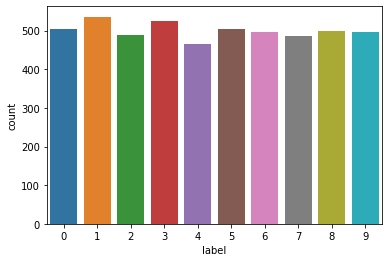

In [9]:
sns.countplot(y_train.label)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


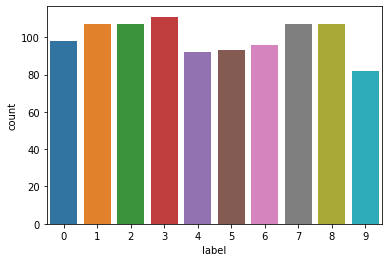

In [10]:
sns.countplot(y_test.label)
plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

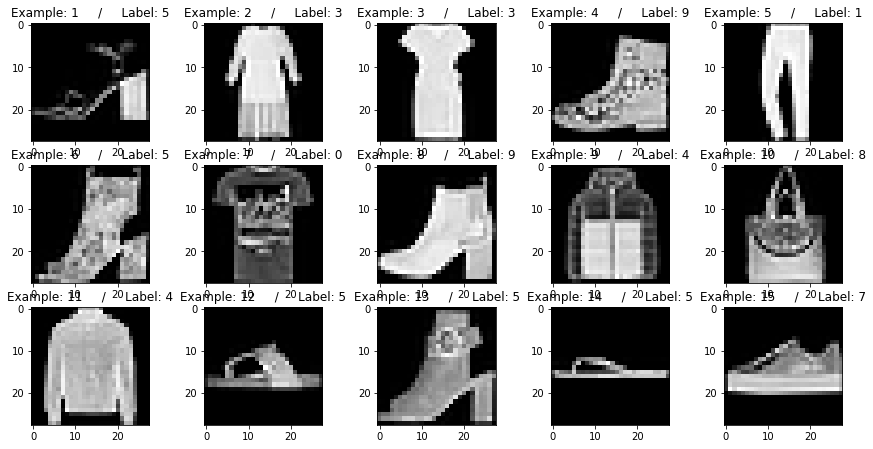

In [28]:
plt.figure(figsize=(15,10))
for i in range(1,16):
  plt.subplot(4,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [12]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

(5000, 784) (1000, 784)


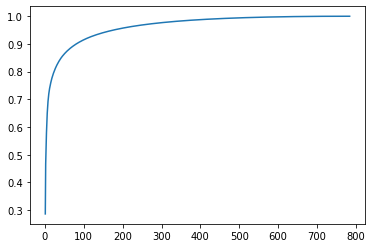

In [13]:
cumulative=[]
temp=0
for i in range(784):
  temp+=pca.explained_variance_ratio_[i]
  cumulative.append(temp)

plt.plot(range(1,785), cumulative)
plt.show()

In [14]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #23개 쓰면 분산의 80%이상을 설명

23

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [15]:
pca=PCA(n_components=23) 
X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)
print(X_train_PCA.shape, X_test_PCA.shape)

(5000, 23) (1000, 23)


In [16]:
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy: 1.0
test accuracy: 0.777
63.7329sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy: 0.8234
test accuracy: 0.821
8.4543sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression에 있어 차원 축소 이전과 이후 성능을 비교해보았다. PCA를 통해 차원축소한 결과 학습 속도가 현저하게 감소하였다. 또한, 성능 측면에서도 과적합되지 않고 일반적인 데이터에 대해서도 더 높은 성능을 보이는 것으로 보인다. 차원 축소 이전 train accuracy는 100%이지만, test accuracy는 77%로 차원 축소 이후 성능인 82%보다 더 낮은 것을 볼 수 있다. 즉, PCA를 통한 차원 축소로 성능 향상 및 학습 속도 개선의 효과를 보인다. 차원의 저주를 어느정도 해결한 것으로 보인다.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

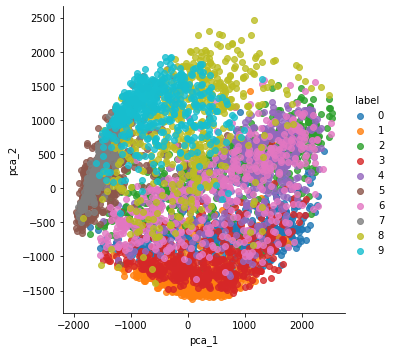

In [18]:
#PCA
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train)
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.0150sec


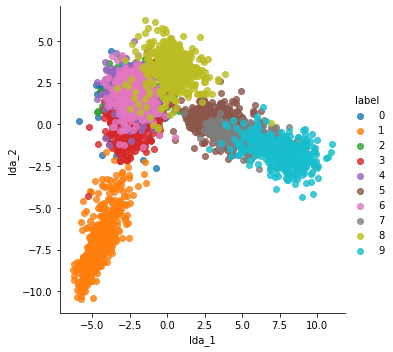

In [19]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

3.2309sec


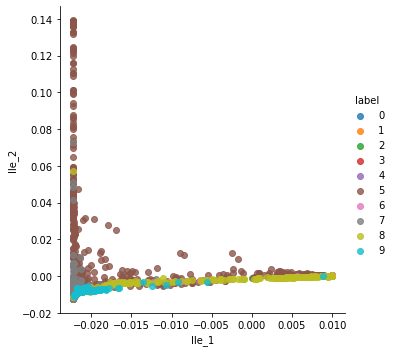

In [20]:
#LLE
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5, random_state=42)
X_train_lle = lle.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

25.5749sec


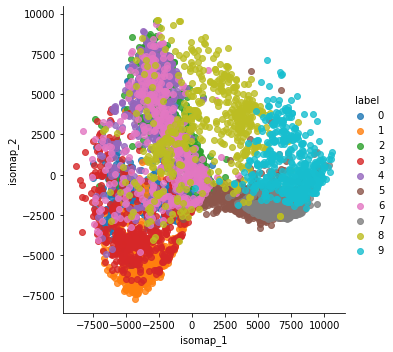

In [21]:
#ISOMAP
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         

X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


71.1133sec


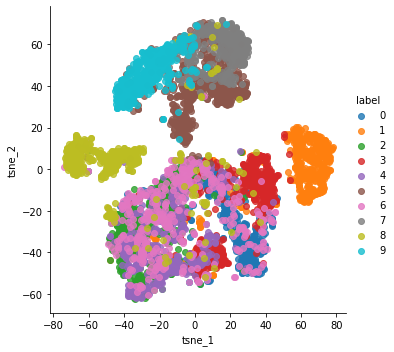

In [22]:
#t-SNE
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

LDA, t-SNE, ISOMAP이 비교적 데이터의 특성을 잘 반영하여 차원 축소를 잘 했다고 볼 수 있다. 

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

차원 축소 결과 2번 라벨과 6번 라벨은 겹쳐서 분포하는 경우가 많다. 차원 축소 이후 이 두개의 특성을 명확하게 구분해내기는 쉽지 않다는 말이다. 2번 라벨은 pullover이고 6번 라벨은 shirt이다. 이후, 해당 라벨에 대해서 이미지를 나타내보이니 비슷한 특성을 지니는 것으로 보이고, 잘 구분하기 어려워보인다.

In [39]:
y_train[y_train['label']==2].index[0]

21

In [40]:
y_train[y_train['label']==6].index[0]

34

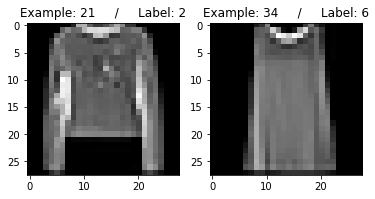

In [47]:
plt.subplot(1,2,1)
label=y_train.loc[21]
image=X_train.loc[21,:].values.reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.title('Example: %d     /     Label: %d'%(21, label))

plt.subplot(1,2,2)
label=y_train.loc[34]
image=X_train.loc[34,:].values.reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.title('Example: %d     /     Label: %d'%(34, label))
plt.show()

수고하셨습니다~